In [1]:
import librosa
import numpy as np
import torch
import torchaudio
import matplotlib.pyplot as plt
import os

from birdclassification.preprocessing.utils import *
from birdclassification.preprocessing.spectrogram import generate_mel_spectrogram, normalize_spectrogram_for_display
from birdclassification.visualization.plots import *

In [2]:
input_filename = '../../../tests/sounds/cygnus_olor_2.mp3'
sr = 32000
n_fft = 512 
hop_length = 3 * 128
sample_length = 3

In [3]:
def plot_torch_spectrogram(specgram, title=None, ylabel="freq_bin", ax=None):
    if ax is None:
        _, ax = plt.subplots(1, 1)
    if title is not None:
        ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto", interpolation="nearest")

In [4]:
y, sr_original = torchaudio.load(input_filename)
y, sr_original

(tensor([[-2.8253e-03, -3.9972e-03, -3.8381e-03,  ...,  6.7760e-05,
           2.1647e-04,  6.3441e-04]]),
 48000)

In [5]:
if sr_original != sr:
  y = torchaudio.transforms.Resample(orig_freq=sr_original, new_freq=sr)(y)

y, sr

(tensor([[-0.0026, -0.0041, -0.0035,  ...,  0.0004,  0.0001,  0.0005]]), 32000)

In [6]:
spectrogram = generate_mel_spectrogram(y, sr, n_fft, hop_length)
spectrogram

array([[-50.73587 , -66.72371 , -58.164482, ..., -52.88523 , -47.763847,
        -53.689903],
       [-55.25935 , -53.45507 , -46.081127, ..., -54.308746, -46.737717,
        -49.63314 ],
       [-54.162506, -50.147575, -45.696526, ..., -51.952866, -45.619724,
        -47.364998],
       ...,
       [-64.51203 , -61.914024, -61.326218, ..., -63.158188, -63.475464,
        -64.70092 ],
       [-66.76679 , -62.175636, -64.43652 , ..., -64.12785 , -62.355957,
        -62.68106 ],
       [-62.167664, -62.284775, -65.826385, ..., -62.438354, -63.46637 ,
        -62.948013]], dtype=float32)

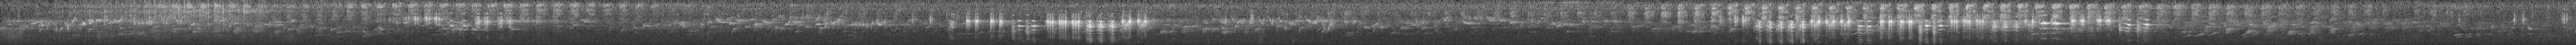

In [7]:
array_to_image(normalize_spectrogram_for_display(spectrogram))

Function: 'create_spectrogram_torch', execution time: 0.013069629669189453


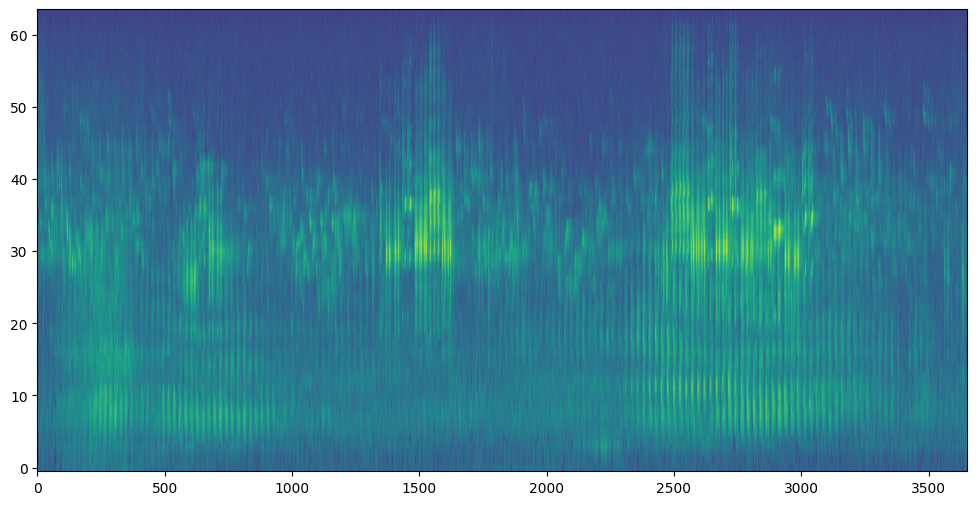

In [8]:
@timer
def create_spectrogram_torch(y):
  transform = torchaudio.transforms.MelSpectrogram(sample_rate=sr, n_fft=n_fft, hop_length=hop_length, f_min=150, f_max=15000, n_mels=64)
  return transform(y)[0]

spectrogram_torch = create_spectrogram_torch(y)

plt.figure(figsize=(12, 6))
plt.imshow(librosa.power_to_db(spectrogram_torch), origin="lower", aspect="auto")

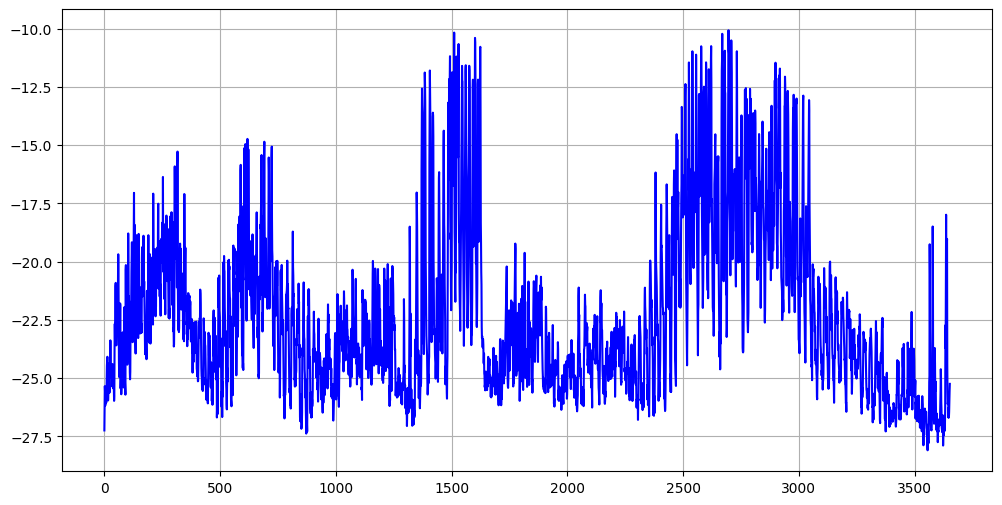

In [9]:
loudness = convert_waveform_to_loudness(y, n_fft, hop_length)

plt.figure(figsize=(12, 6))
plt.plot(librosa.power_to_db(loudness), color='blue')
plt.grid()

In [10]:
peak = get_loudest_index(y, n_fft, hop_length)
peak

1035520

In [11]:
peak / hop_length

2696.6666666666665

In [12]:
loudness.argmax()

2696

In [13]:
y_cut = cut_around_index(y, peak, sr * sample_length)
y_cut

tensor([[-0.0091, -0.0116, -0.0124,  ...,  0.0026,  0.0085,  0.0146]])

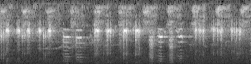

In [14]:
spectrogram_cut = generate_mel_spectrogram(y_cut, sr, n_fft, hop_length)
array_to_image(normalize_spectrogram_for_display(spectrogram_cut))

In [15]:
start_index = None
end_index = None

for i in range(y.size(1) - y_cut.size(1) + 1):
    if torch.all(y[:, i:i + y_cut.size(1)] == y_cut):
        start_index = i
        end_index = i + y_cut.size(1) - 1
        break
    
start_index, end_index

(987520, 1083519)

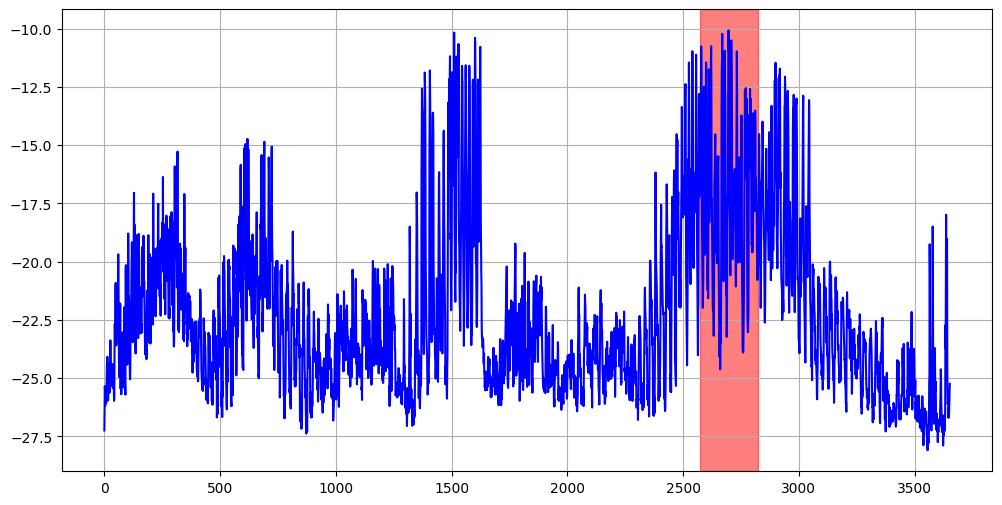

In [16]:
plt.figure(figsize=(12, 6))
plt.plot(librosa.power_to_db(loudness), color='blue')
plt.axvspan(start_index / hop_length, end_index / hop_length, color='red', alpha=0.5)
plt.grid()

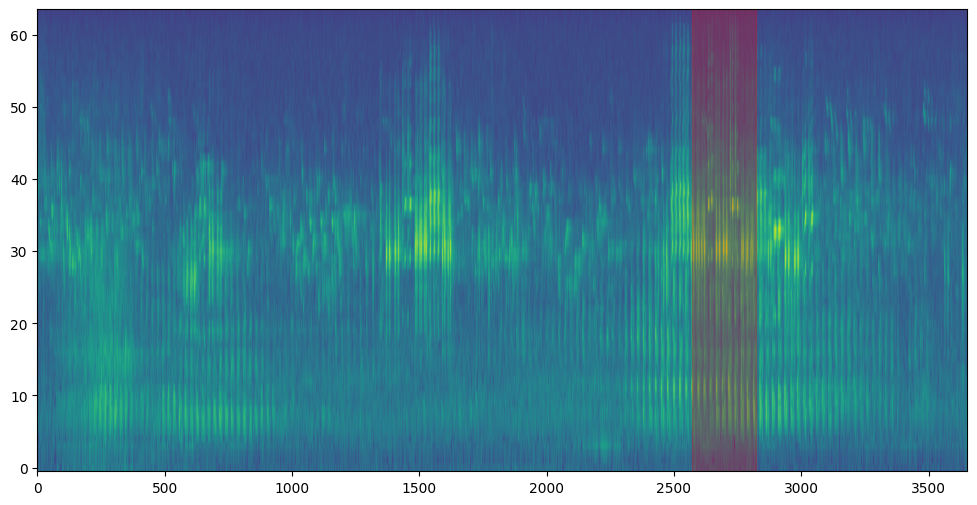

In [17]:
plt.figure(figsize=(12, 6))
plt.imshow(librosa.power_to_db(spectrogram_torch), origin="lower", aspect="auto")
plt.axvspan(start_index / hop_length, end_index / hop_length, color='red', alpha=0.25)